In [ ]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree

## Dataset

In [ ]:
df=pd.DataFrame()
df['Name']=['Batman','Superman','Flash','Thanos','Ironman','Hulk']
df['Attendance']=[1,1,0,1,0,0]
df['Marks']=[10,90,30,10,30,50]
df['Branch']=['ME','CSE','ME','EE','CSE','ME']
df['loves_subject']=[1,1,0,0,1,1]
print('Data:')
display(df)

X=df[['Attendance','Marks']].copy()
X['CSE']=0
X.loc[df['Branch']=='CSE','CSE']=1
X['ME']=0
X.loc[df['Branch']=='ME','ME']=1
X['EE']=0
X.loc[df['Branch']=='EE','EE']=1

y=df['loves_subject']
print('X:')
display(X)
n=df.shape[0]

Data:


,Name,Attendance,Marks,Branch,loves_subject
0,Batman,1,10,ME,1
1,Superman,1,90,CSE,1
2,Flash,0,30,ME,0
3,Thanos,1,10,EE,0
4,Ironman,0,30,CSE,1
5,Hulk,0,50,ME,1


X:


,Attendance,Marks,CSE,ME,EE
0,1,10,0,1,0
1,1,90,1,0,0
2,0,30,0,1,0
3,1,10,0,0,1
4,0,30,1,0,0
5,0,50,0,1,0


## Initial Step for Calculating log(odds)

In [ ]:
log_odd_0=np.log( np.count_nonzero(y==1)/ np.count_nonzero(y==0))
prob_0=np.exp(log_odd_0)/(np.exp(log_odd_0)+1)
n_samples=len(X)
print(f'the log_of_odds is : {log_odd_0}')
print(f'the probability is : {prob_0}')
print('the prediction is: ' + str((prob_0>0.5)*1.0))

loss_0=-(y*np.log(prob_0)+(1-y)*np.log(1-prob_0))

the log_of_odds is : 0.6931471805599453
the probability is : 0.6666666666666666
the prediction is: 1.0


## Parameters

In [ ]:
n = 5
learning_rate=0.8

log_of_odds=np.zeros([n+1,n_samples])
residuals = np.zeros([n+1,n_samples])
loss = [0] * (n+1)
probabilities = np.zeros([n+1,n_samples])
y_pred = np.zeros([n+1,n_samples])
score = np.zeros([n+1])

# Array Initialization
log_of_odds[0] = [log_odd_0] * n_samples
probabilities[0] = [prob_0] * n_samples
y_pred[0] = (probabilities[0]>=0.5)*1.0
score[0]=np.sum(y_pred[0]==y) / n_samples
residuals[0] = y - probabilities[0]
loss[0] = loss_0.sum()
trees = []
max_leaves = 3
gamma_value = np.zeros([n+1,max_leaves])
gamma = np.zeros([n+1,n_samples])

In [ ]:
def iteration(i):

  # Calculate the residuals
  residuals[i] = y - probabilities[i]
  
  # Fit a regression tree
  dt = DecisionTreeRegressor(max_depth=1, max_leaf_nodes=3)
  dt=dt.fit(X, residuals[i])
  trees.append(dt.tree_)

  # Calculate gamma
  leaf_indeces=dt.apply(X)
  unique_leaves=np.unique(leaf_indeces)
  n_leaf=len(unique_leaves)
  print("Number of leaves ", n_leaf)
  print("Indices for data", leaf_indeces)

  for ileaf in range(n_leaf):      
    leaf_index=unique_leaves[ileaf]
    n_leaf=len(leaf_indeces[leaf_indeces==leaf_index])
    previous_probability = probabilities[i][leaf_indeces==leaf_index]
    denominator = np.sum(previous_probability * (1-previous_probability))
    igamma = (dt.tree_.value[ileaf+1][0][0] * n_leaf) / denominator
    gamma_value[i][ileaf]=igamma
    print(f'for leaf {leaf_index}, we have {n_leaf} related samples. and gamma is {igamma}')

  gamma[i] = [gamma_value[i][np.where(unique_leaves==index)] for index in leaf_indeces]

  # Update F(x) 
  log_of_odds[i+1] = log_of_odds[i] + learning_rate * gamma[i]

  probabilities[i+1] = np.array([np.exp(odds)/(np.exp(odds)+1) for odds in log_of_odds[i+1]])
  y_pred[i+1] = (probabilities[i+1]>0.5)*1.0
  score[i+1]=np.sum(y_pred[i+1]==y) / n_samples
  loss[i+1]=np.sum(-y * log_of_odds[i+1] + np.log(1+np.exp(log_of_odds[i+1])))

  new_df=df.copy()
  new_df.columns=['Name', 'Attendance','Marks','Branch','loves_subject']
  new_df[f'l_{i}']=log_of_odds[i]
  new_df[f'p_{i}']=probabilities[i]
  new_df[f'r_{i}']=residuals[i]
  new_df[f'gamma_{i}']=gamma[i]
  new_df[f'l_{i+1}']=log_of_odds[i+1]
  new_df[f'p_{i+1}']=probabilities[i+1]
  display(new_df)

In [ ]:
iteration(0)

Number of leaves  2
Indices for data [1 1 1 2 1 1]
for leaf 1, we have 5 related samples. and gamma is 0.6000000000000001
for leaf 2, we have 1 related samples. and gamma is -2.9999999999999996


,Name,Attendance,Marks,Branch,loves_subject,l_0,p_0,r_0,gamma_0,l_1,p_1
0,Batman,1,10,ME,1,0.693147,0.666667,0.333333,0.6,1.173147,0.763713
1,Superman,1,90,CSE,1,0.693147,0.666667,0.333333,0.6,1.173147,0.763713
2,Flash,0,30,ME,0,0.693147,0.666667,-0.666667,0.6,1.173147,0.763713
3,Thanos,1,10,EE,0,0.693147,0.666667,-0.666667,-3.0,-1.706853,0.153572
4,Ironman,0,30,CSE,1,0.693147,0.666667,0.333333,0.6,1.173147,0.763713
5,Hulk,0,50,ME,1,0.693147,0.666667,0.333333,0.6,1.173147,0.763713


In [ ]:
iteration(1)

Number of leaves  2
Indices for data [1 2 1 1 2 1]
for leaf 1, we have 4 related samples. and gamma is -0.6624118798340858
for leaf 2, we have 2 related samples. and gamma is 1.3093916959030705


,Name,Attendance,Marks,Branch,loves_subject,l_1,p_1,r_1,gamma_1,l_2,p_2
0,Batman,1,10,ME,1,1.173147,0.763713,0.236287,-0.662412,0.643218,0.655480
1,Superman,1,90,CSE,1,1.173147,0.763713,0.236287,1.309392,2.220661,0.902090
2,Flash,0,30,ME,0,1.173147,0.763713,-0.763713,-0.662412,0.643218,0.655480
3,Thanos,1,10,EE,0,-1.706853,0.153572,-0.153572,-0.662412,-2.236782,0.096496
4,Ironman,0,30,CSE,1,1.173147,0.763713,0.236287,1.309392,2.220661,0.902090
5,Hulk,0,50,ME,1,1.173147,0.763713,0.236287,-0.662412,0.643218,0.655480


In [ ]:
iteration(2)

Number of leaves  2
Indices for data [1 2 1 1 1 2]
for leaf 1, we have 4 related samples. and gamma is -0.49356816535595666
for leaf 2, we have 2 related samples. and gamma is 1.4083407428723145


,Name,Attendance,Marks,Branch,loves_subject,l_2,p_2,r_2,gamma_2,l_3,p_3
0,Batman,1,10,ME,1,0.643218,0.655480,0.344520,-0.493568,0.248363,0.561774
1,Superman,1,90,CSE,1,2.220661,0.902090,0.097910,1.408341,3.347333,0.966017
2,Flash,0,30,ME,0,0.643218,0.655480,-0.655480,-0.493568,0.248363,0.561774
3,Thanos,1,10,EE,0,-2.236782,0.096496,-0.096496,-0.493568,-2.631637,0.067130
4,Ironman,0,30,CSE,1,2.220661,0.902090,0.097910,-0.493568,1.825806,0.861261
5,Hulk,0,50,ME,1,0.643218,0.655480,0.344520,1.408341,1.769890,0.854444


In [ ]:
iteration(3)

Number of leaves  2
Indices for data [1 2 2 1 2 2]
for leaf 1, we have 2 related samples. and gamma is 1.201708442432531
for leaf 2, we have 4 related samples. and gamma is -0.46569060807109836


,Name,Attendance,Marks,Branch,loves_subject,l_3,p_3,r_3,gamma_3,l_4,p_4
0,Batman,1,10,ME,1,0.248363,0.561774,0.438226,1.201708,1.209730,0.770251
1,Superman,1,90,CSE,1,3.347333,0.966017,0.033983,-0.465691,2.974781,0.951422
2,Flash,0,30,ME,0,0.248363,0.561774,-0.561774,-0.465691,-0.124189,0.468993
3,Thanos,1,10,EE,0,-2.631637,0.067130,-0.067130,1.201708,-1.670270,0.158388
4,Ironman,0,30,CSE,1,1.825806,0.861261,0.138739,-0.465691,1.453254,0.810499
5,Hulk,0,50,ME,1,1.769890,0.854444,0.145556,-0.465691,1.397338,0.801761


In [ ]:
iteration(4)

Number of leaves  2
Indices for data [1 2 1 1 1 2]
for leaf 1, we have 4 related samples. and gamma is -0.29195118439248596
for leaf 2, we have 2 related samples. and gamma is 1.2030550851532074


,Name,Attendance,Marks,Branch,loves_subject,l_4,p_4,r_4,gamma_4,l_5,p_5
0,Batman,1,10,ME,1,1.209730,0.770251,0.229749,-0.291951,0.976169,0.726347
1,Superman,1,90,CSE,1,2.974781,0.951422,0.048578,1.203055,3.937225,0.980871
2,Flash,0,30,ME,0,-0.124189,0.468993,-0.468993,-0.291951,-0.357750,0.411504
3,Thanos,1,10,EE,0,-1.670270,0.158388,-0.158388,-0.291951,-1.903831,0.129675
4,Ironman,0,30,CSE,1,1.453254,0.810499,0.189501,-0.291951,1.219693,0.772009
5,Hulk,0,50,ME,1,1.397338,0.801761,0.198239,1.203055,2.359782,0.913709


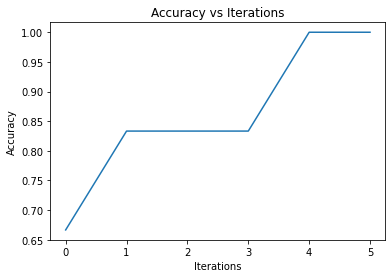

In [ ]:
plt.plot(score)
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iterations")
plt.show()

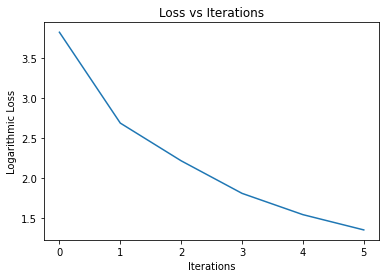

In [ ]:
plt.plot(loss)
plt.xlabel("Iterations")
plt.ylabel("Logarithmic Loss")
plt.title("Loss vs Iterations")
plt.show()